# Histopathologic Cancer Detection

https://www.kaggle.com/competitions/histopathologic-cancer-detection

https://www.kaggle.com/code/conradkleykamp/histopathologic-cancer-detection-cnn-keras

Identify metastatic tissue in histopathologic scans of lymph node sections

In this competition, you must create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans. The data for this competition is a slightly modified version of the PatchCamelyon (PCam) benchmark dataset (the original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates).

PCam is highly interesting for both its size, simplicity to get started on, and approachability. In the authors' words:

[PCam] packs the clinically-relevant task of metastasis detection into a straight-forward binary image classification task, akin to CIFAR-10 and MNIST. Models can easily be trained on a single GPU in a couple hours, and achieve competitive scores in the Camelyon16 tasks of tumor detection and whole-slide image diagnosis. Furthermore, the balance between task-difficulty and tractability makes it a prime suspect for fundamental machine learning research on topics as active learning, model uncertainty, and explainability.

# About the Data / Problem
This dataset and task can be found on Kaggle. The overarching task here is to 'create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans'. This task translates well to a binary classification problem. More specifically, a convolutional neural network (CNN) will be used to divide the images from the dataset into two classes, i.e. having cancer and not having cancer.

The dataset consists of microscopic images of lymph node tissue. Each image has a resolution of 96x96 pixels, and the task will be to identify metastatic cancer tissue in a 32x32 pixel center region of the image. According to the Kaggle competition description, the identification of at least 1 pixel of tumor tissue would effectively label the image as positive, i.e. having cancer. The train dataset consists of 220,025 images, while the test dataset contains 57,468 images.

As this was my first attempt at developing a CNN using Keras, this project was highly influenced by other works, primarily one by Pablo Gómez. All other inspirational works have been listed in the reference section.

In [1]:
# Carga de librerias necesarias
from glob import glob 
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',None)
pd.set_option('max_colwidth', None)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import os, cv2
#import keras,cv2,os
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tqdm import tqdm_notebook,trange
import matplotlib.pyplot as plt
import gc 

In [ ]:
#pip install opencv-python
#pip install jupyter --upgrade
#pip install ipywidgets widgetsnbextension --upgrade
#!jupyter nbextension enable --py widgetsnbextension

In [2]:
path = os.path.join(os.path.abspath(os.getcwd()), "Dataset_cancer_detection")
train_path = os.path.join(path, 'train')
test_path = os.path.join(path, 'test')

In [3]:
# Creating a dataframe from the train_path filenames and lables
df = pd.DataFrame({'path': glob(os.path.join(train_path,'*.tif'))}) 
df['id'] = df.path.map(lambda x: os.path.split(x)[1].split(".")[0]) 
labels = pd.read_csv(path+"\\train_labels.csv") 
df = df.merge(labels, on = "id") 


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   path    220025 non-null  object
 1   id      220025 non-null  object
 2   label   220025 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 5.0+ MB


In [4]:
# Loading N images from df dataframe
def load_data(N,df):
    X = np.zeros([N,96,96,3],dtype=np.uint8) 
    y = np.squeeze(df['label'].iloc[0:N].values)
    for i, row in tqdm_notebook(df.iterrows(), total=N):
        if i == N:
            break
        X[i] = cv2.imread(row['path'])     
    return X,y

In [ ]:
# Loading 10000 images
N=100
X,y = load_data(N=N,df=df) 

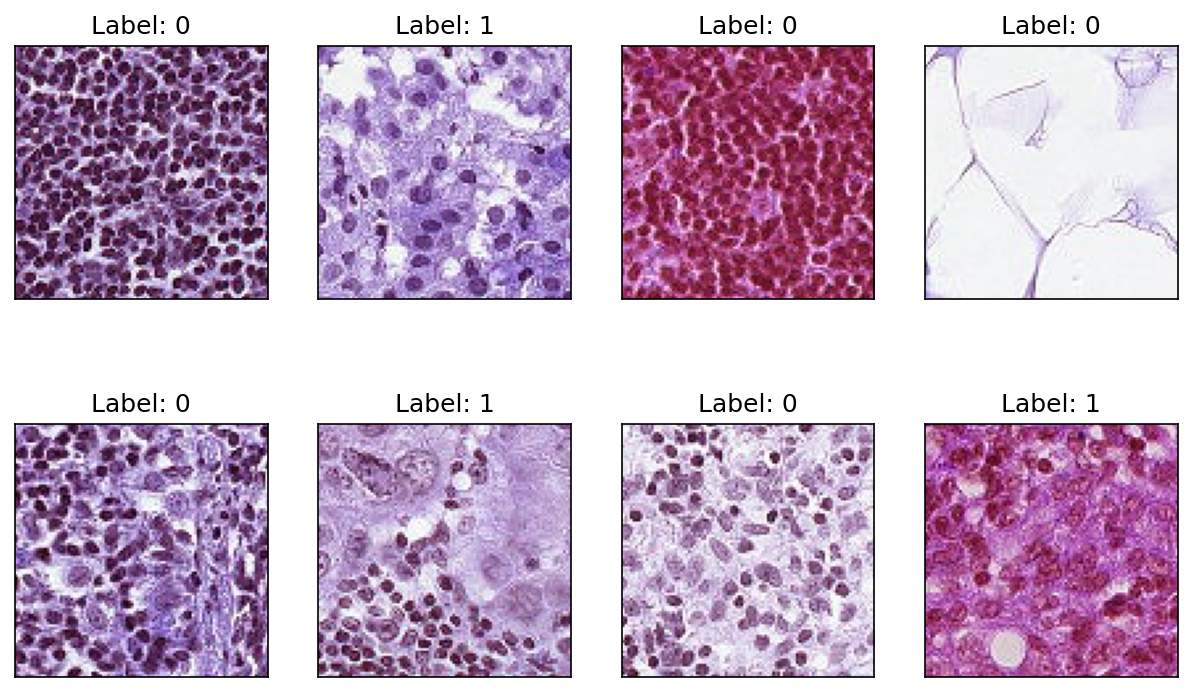

In [10]:
# Visualizing a set of random images
fig = plt.figure(figsize=(10, 6), dpi=150)
for plotNr,idx in enumerate(np.random.randint(0,N,8)):
    ax = fig.add_subplot(2, 8//2, plotNr+1, xticks=[], yticks=[]) 
    plt.imshow(X[idx]) 
    ax.set_title('Label: ' + str(y[idx])) 

The images above represent random examples of tissue with and without evidence of cancer. Changing the random.seed in the code chunk above will result in different examples being shown. An image labeled as 0 represents tissue WITHOUT cancer and an image labeled as 1 represents tissue WITH cancer. As I have zero knowledge or background in histopathology, it would be unlikely that I could correctly identify a tumor in any given tissue. However, upon visualizing several sets of random images, it seems as though the tissues with large white dots often warrant a positive label. From this, one could deduce that these large white dots are tumors. Although this doesn't necessarily help us here, it is definitely interesting.

# CONSTRUCCIÓN DEL MODELO

In [43]:
# Loading images from the training set
N = int(np.round(df["path"].size*0.1))
X,y = load_data(N=N,df=df)

C:\Users\ivdgo\AppData\Local\Temp\ipykernel_4664\2187102320.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, row in tqdm_notebook(df.iterrows(), total=N):


  0%|          | 0/22002 [00:00<?, ?it/s]

In [44]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,stratify=y,random_state=123)

In [45]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Resizing, Rescaling
from keras.losses import BinaryCrossentropy
from keras.optimizers import SGD
from keras.metrics import BinaryAccuracy, Precision, Recall
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [64]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.05,
    patience=3
)

In [46]:
preprocess = Sequential([])
preprocess.add(Resizing(196,196,interpolation='bilinear',input_shape=(None,None,3)))
preprocess.add(Rescaling(1./255))

In [69]:
def get_model(preprocess):   

    model = Sequential([])
    model.add(preprocess)
    model.add(Conv2D(16,(3,3),activation='LeakyReLU'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(64,(3,3),activation='LeakyReLU'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(16,(3,3),activation='LeakyReLU'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    # model.add(Conv2D(64,(3,3),activation='relu'))
    # model.add(MaxPooling2D(strides=16,pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(300,activation='LeakyReLU'))
    model.add(Dropout(0.2))
    model.add(Dense(256,activation='LeakyReLU'))
    model.add(Dropout(0.2))
    model.add(Dense(1,activation='sigmoid'))

    model.compile(
        optimizer=SGD(0.03),
        loss=BinaryCrossentropy(),
        metrics=[BinaryAccuracy('accuracy')]
    )


    return model

In [70]:
model = get_model(preprocess)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 196, 196, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 194, 194, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 97, 97, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 95, 95, 64)        9280      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 47, 47, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 45, 45, 16)       

In [71]:
history = model.fit(
    X_train,y_train,
    validation_data=(X_test,y_test),
    epochs=16,
    verbose=2,
    callbacks=[early_stopping]
)

Epoch 1/16
482/482 - 160s - loss: 0.6321 - accuracy: 0.6487 - val_loss: 0.5701 - val_accuracy: 0.7123 - 160s/epoch - 333ms/step
Epoch 2/16
482/482 - 162s - loss: 0.5254 - accuracy: 0.7481 - val_loss: 0.5180 - val_accuracy: 0.7425 - 162s/epoch - 336ms/step
Epoch 3/16
482/482 - 163s - loss: 0.4786 - accuracy: 0.7822 - val_loss: 0.5142 - val_accuracy: 0.7596 - 163s/epoch - 337ms/step
Epoch 4/16


In [68]:
val_loss, val_acc = model.evaluate(X_test,y_test)

207/207 [==============================] - 14s 67ms/step - loss: 0.5231 - accuracy: 0.7661


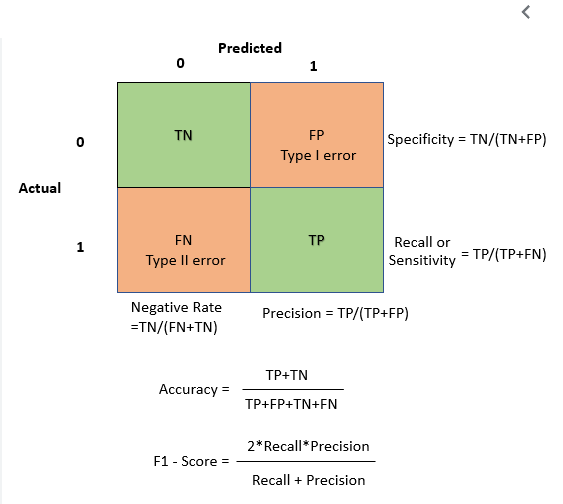